# TODO To save the coordinates to SoundSep for the UMAP vis to work I need to add commas using javascript object notation. Since Logan has basically implemented this entire DF in soundsep though, it's probably not relevant....
## Read biosound H5 files and cluster
### After sorting some syllables/notes/calls in SoundSep you must first calculate spectral/temporal features of them with Biosound and store those features as H5 files. This is all done with save_biosound_h5files.ipynb.
### This notebook takes the H5 files, makes a Pandas DF, and does some clustering on them.

In [1]:
# from scipy import integrate, optimize

from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import datetime
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA



# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt

def plot_a_spectrogram(w, fs:int=48000, title:str=spectrogram, nfft:int=2048):
    ff, tt, Sxx = spectrogram(w, fs=fs, nfft=nfft)
    max_ff = 10000 # only plot the first 10kHz
    ff_index = np.where(ff < max_ff)
    ff = ff[ff_index]
    Sxx = Sxx[ff_index]

    plt.figure(figsize=(2, 2))
    plt.pcolormesh(tt, ff[:max_ff], Sxx[:max_ff], cmap='plasma', shading='auto')
    # plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='plasma', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()


def print_missing_features(X, XFeatureNames, indBad):
    missing_features = list()
    for feature in XFeatureNames:
        num_missing=0
        for i in indBad: 
            if np.isnan(X[i,np.where(XFeatureNames == feature)[0][0]]):
                num_missing += 1
        if num_missing > 0: print(f'num missing {feature} = {num_missing}')

In [2]:
base_folder = "/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023"# _Maeves_data"
h5_folder = 'h5filesAmp'

fs = 48000 # TODO find where to import fs instead of hardcoding it

os.chdir(os.path.join(base_folder, h5_folder))
print(os.getcwd())
files_list = os.listdir('.')
print(f'num files = {len(files_list)}, files_list[0] = {files_list[0]}')

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/h5filesAmp
num files = 4345, files_list[0] = bird_WhiWhi6607F_call_["0"]_1134.h5


In [3]:
# Testing with one file
fname = files_list[1]

myBioSound = BioSound()
myBioSound.readh5(fname)
        
# Take the time average formants 
meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
        
# These are our two identifier - the emitter (bird) and the call type
Bird = np.array2string(myBioSound.emitter)[2:-1]
callType = np.array2string(myBioSound.type)[2:-1]

print("The following values shouldn't be NaN or 0")
print(f'meanF1 = {meanF1}, meanF2 = {meanF2}, meanF3 = {meanF3}, Bird = {Bird}, callType = {callType}')

The following values shouldn't be NaN or 0
meanF1 = 1223.1475918116207, meanF2 = 4405.922739456839, meanF3 = 9015.34493500762, Bird = BluGre1214F, callType = ["6"]


## If you have previously saved a pandas df from the H5 files you can skip the next two cells
# in many ways however this is the meat of this notebook

In [4]:
# # vocSelData is going to be a list of dictionary containing the values that we are going to extract from each BioSound object.
# vocSelData = []

# # Looping through all the files
# i = 0
# for fname in files_list:
#     if fname.endswith('.h5'):
#         # print(f'index = {i}, fname = {fname}')
#         # print(fname)
#         # Allocate object and read data
#         myBioSound = BioSound()
#         try:
#             myBioSound.readh5(fname)
#         except:
#             print('Could not read h5 file', fname)
#             continue
        
#         # These are our two identifier - the emitter (bird) and the call type
#         Bird = np.array2string(myBioSound.emitter)[2:-1]
#         callType = np.array2string(myBioSound.type)[2:-1]

#         # Get values for the fundamental
#         if myBioSound.fund.size > 0:
#             fund = float(myBioSound.fund)
#             cvfund = float(myBioSound.cvfund)
#             maxfund = float(myBioSound.maxfund)
#             minfund = float(myBioSound.minfund)
#             devfund = np.nanmean(np.diff(myBioSound.f0))
#                     # Take the time average formants 
#             meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
#             meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
#             meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
#         else:
#             fund = -10 
#             cvfund = 0   
#             maxfund = 0
#             # TODO add default value of devfund
#             # TODO just notes here: play with UMAP neighborhood.
#             # TODO play with HDBScan neighborhood. fit it. silhouette score. davis dun score. 
#             # TODO # of unclassified calls.
#             # TODO try to classifiy noise vs calls. force 2 clusters.
#             # then look at soundsep. 
#             minfund = 0
#             devfund = 0
#             meanF1 = 0
#             meanF2 = 0
#             meanF3 = 0
            

#         vocSelData.append({"Bird": Bird, 
#                      "project.start_index": int(fname.split('.')[0].split('_')[-1]),
#                      "calltype": callType, 
#                      "fund": fund, "devfund": devfund,
#                      "cvfund": cvfund, "maxfund": maxfund, "minfund": minfund,
#                      "F1": meanF1, "F2": meanF2, "F3":meanF3,
#                      "sal": float(myBioSound.meansal), 
#                      "rms": float(myBioSound.rms), 
#                      "maxAmp": float(myBioSound.maxAmp),
#                      "meanS": float(myBioSound.meanspect), "stdS": float(myBioSound.stdspect),
#                      "skewS": float(myBioSound.skewspect), "kurtS": float(myBioSound.kurtosisspect), 
#                      "entS": float(myBioSound.entropyspect),
#                      "q1": float(myBioSound.q1), "q2": float(myBioSound.q2), "q3": float(myBioSound.q3),                  
#                      "meanT": float(myBioSound.meantime), "stdT": float(myBioSound.stdtime),
#                      "skewT": float(myBioSound.skewtime), "kurtT": float(myBioSound.kurtosistime),
#                      "entT": float(myBioSound.entropytime)
        
# })
#         i += 1
#         if ((i % 1000) == 0):
#             print('Done with', i, 'files')
#         #if (i == 10000):
#             #break

# print(f'Done with {i} files')


In [5]:
# Write the results to a pandas df

# tableStore = os.path.join(base_folder,'vocSelTableAmp.h5')
# vocSelTable = pd.DataFrame(vocSelData)
# vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')

## If you already stored the H5 file just load it, skipping the above cells
## Either way, at this point we will also need to load the soundsep syllable csv from a couple steps up the pipeline

In [6]:
# You can also start the script here and skip the reading of h5 files and creation of table
# Read the vocSelTable
vocSelTable = pd.read_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5')) # 
print(f"loading file: {os.path.join(base_folder, 'vocSelTableAmp.h5')} with {len(vocSelTable)} syllables")

loading file: /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/vocSelTableAmp.h5 with 4344 syllables


In [7]:
# Read the annotated syllabes.csv (soundsep metadata) to get information on solo vs overlap and what tags were manually entered
syll_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
# backup_name = os.path.join(base_folder,'_appdata','save','segments_backup_good.csv')
syllTable = pd.read_csv(syll_file_name, sep=',',header=0) 
print(f"loading {syll_file_name} with {len(syllTable)} syllables")

birds = np.unique(vocSelTable['Bird'])
print(f'birds = {birds}')

loading /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv with 4344 syllables
birds = ['BluGre1214F' 'BroGre1354M' 'WhiWhi1541M' 'WhiWhi6607F']


In [10]:
# Now we merge the syllTable (soundsep metadata) and the vocSelTable (biosound features).TextDisplayObject
# The indices ARE NOT THE SAME, so we can't just merge the tables on the index
# the index of vocSelTable is 'project.start_index' column
# and the index of syllTable is the index

# might as well check if the indices are the same while I'm at it
if np.array_equal(vocSelTable.index, syllTable.index):
    # sort vocSelTable by 'project.start_index' column
    vocSelTable = vocSelTable.sort_values(by='project.start_index')

    # make the index of vocSelTable the 'project.start_index' column
    vocSelTable.index = vocSelTable['project.start_index'].values
    # # drop the 'project.start_index' column
    vocSelTable = vocSelTable.drop(columns=['project.start_index'])
    vocSelTableFull = pd.merge(vocSelTable, syllTable, left_index=True, right_index=True)

    # also sort the files_list by 'project.start_index' column
    files_list = [[f, int(f.split('.')[0].split('_')[-1])] for f in files_list if f.endswith('.h5')]
    files_list = pd.DataFrame(files_list, columns=['file', 'project.start_index'])
    files_list = files_list.sort_values(by='project.start_index')
    files_list.index = files_list['project.start_index'].values
    files_list = files_list['file']

else:
    print('The indices are not the same this is a problem, a big problem')
vocSelTableFull

,Bird,calltype,fund,devfund,cvfund,maxfund,minfund,F1,F2,F3,...,kurtT,entT,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords
0,BroGre1354M,"[""1""]",508.574590,-0.740855,0.045986,527.472527,436.363636,1664.044399,3561.528246,8596.893613,...,1.959314,0.989150,0,BroGre1354M,0,705034,709502,"[""8""]",0.0,[10.697502 9.804635 7.993754]
1,BluGre1214F,"[""6""]",523.880794,-1.720430,0.011674,533.333333,516.129032,3271.703942,6280.586421,9217.829837,...,2.109855,0.986979,1,BluGre1214F,2,739121,741816,"[""tet""]",5.0,[10.666748 7.427887 3.884933]
2,BluGre1214F,"[""2""]",548.575055,-2.208039,0.027101,564.705882,516.129032,4135.587818,9121.142787,NaN,...,2.189062,0.960172,2,BluGre1214F,2,773851,776369,"[""hat""]",1.0,[10.273127 5.794117 2.64628 ]
3,BluGre1214F,"[""6""]",557.333804,-2.713336,0.036705,592.592593,527.472527,3192.273235,6348.161057,9158.343416,...,2.201422,0.982954,3,BluGre1214F,2,844891,848558,"[""tet""]",5.0,[10.74689 7.3378167 3.9408872]
4,BroGre1354M,"[""5""]",560.232975,-0.867444,0.035327,578.313253,516.129032,2570.895759,4398.845756,9123.647713,...,2.304452,0.976569,4,BroGre1354M,0,910549,913839,"[""tet""]",4.0,[12.070142 6.447742 1.3894552]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,WhiWhi1541M,"[""5""]",518.037891,-1.209025,0.040681,539.325843,475.247525,1927.627306,3946.935002,9088.130784,...,2.036406,0.990364,4339,WhiWhi1541M,3,297302736,297305283,"[""tet""]",4.0,[13.107664 6.9023438 3.5997097]
4340,BluGre1214F,"[""6""]",536.911375,0.723694,0.153731,592.592593,298.136646,1827.897792,4833.507703,8912.761732,...,1.979158,0.989058,4340,BluGre1214F,2,297324812,297329004,"[""tet""]",5.0,[13.785383 9.68441 4.2628775]
4341,BluGre1214F,"[""6""]",567.024101,0.350191,0.102408,600.000000,296.296296,1765.890567,4526.155286,8829.029019,...,1.894907,0.994484,4341,BluGre1214F,2,297367001,297371644,"[""tet""]",5.0,[13.857406 9.577206 4.476639]
4342,BluGre1214F,"[""6""]",557.353786,0.768246,0.171243,615.384615,290.909091,1829.396367,4179.381920,8804.060975,...,2.121620,0.974212,4342,BluGre1214F,2,298070022,298074525,"[""tet""]",5.0,[12.200228 8.624041 5.4423275]


['["tet"]' '["hat"]' '["3"]' '["call"]' '["DC"]' '["WF"]' '["-2"]' '["8"]'
 '["2"]']
['tet' 'hat' '3' 'call' 'DC' 'WF' '-2' '8' '2']


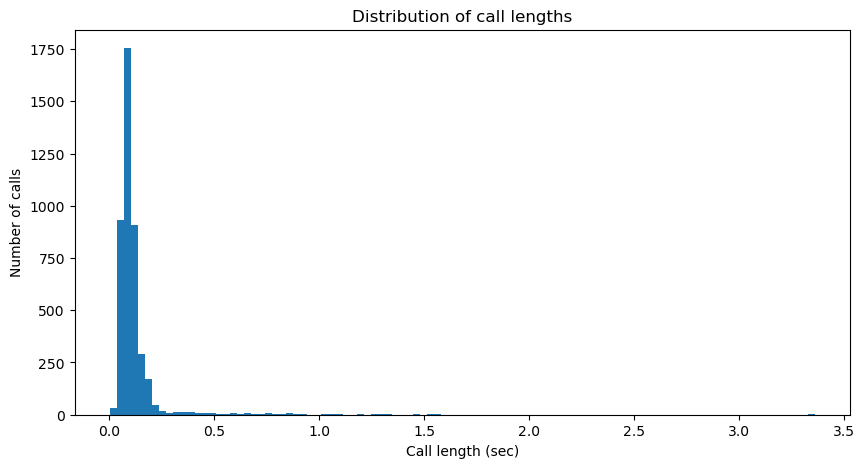

In [24]:
# calculate the length of each call
vocSelTableFull['callLength'] = (vocSelTableFull['StopIndex'] - vocSelTableFull['StartIndex']) / fs
 
# plot the distribution of call lengths
plt.figure(figsize=(10, 5))
plt.hist(vocSelTableFull['callLength'], bins=100)
plt.xlabel('Call length (sec)')
plt.ylabel('Number of calls')
plt.title('Distribution of call lengths')

# The tags have extra characters that I don't want
print(vocSelTableFull['Tags'].unique())
# it appears they have a '[""]' surrounding them
vocSelTableFull['Tags'] = vocSelTableFull['Tags'].str.strip('[""]')
print(vocSelTableFull['Tags'].unique())
# change the tags column of the df to the stripped version
vocSelTableFull['Tags'] = vocSelTableFull['Tags'].str.strip('[""]')

## Now we are going to rearrange the data to do a UMAP projection.
## This requires:
## - taking only some features
## - excluding any rows with NaNs
## - zscore and then calculate PCAs
## - we may also may withhold some data to verify our sorting (not now though)

# I think this is working now but if you want to worry about something you can worry about the finding of bad features in the next two cells, or the index of feature names that's coded by column integer...

In [25]:
# Generate the data array of biosound features
# X is the data array of features.
startFeat = 2
endFeat = 9
startFeat2 = 10
endFeat2 = 26
# note I added callLength to the features, which is the last one
# salInd = 6 # saliency index, I don't think this is good to exclude by

XFeatureNames = np.array(np.hstack((vocSelTableFull.columns[startFeat:endFeat],vocSelTableFull.columns[startFeat2:endFeat2],vocSelTableFull.columns[-1:])))
print('Features chosen:', XFeatureNames)
nfeatures = len(XFeatureNames)

Features chosen: ['fund' 'devfund' 'cvfund' 'maxfund' 'minfund' 'F1' 'F2' 'sal' 'rms'
 'maxAmp' 'meanS' 'stdS' 'skewS' 'kurtS' 'entS' 'q1' 'q2' 'q3' 'meanT'
 'stdT' 'skewT' 'kurtT' 'entT' 'callLength']


In [26]:
# Generate the data array of biosound features
# X is the data array of features.


XBirds = []
indGoodBirds = []
infoBirds = []
nsyllBirds = []
    
X = np.hstack([vocSelTableFull.iloc[:,startFeat:endFeat],vocSelTableFull.iloc[:,startFeat2:endFeat2],vocSelTableFull.iloc[:,-1:]])

# Find the rows that have the full data set

# I was excluding by saliency, but I don't think this is a good idea
# indGood = np.where((np.sum(np.invert(np.isnan(X)), axis=1) == nfeatures) & (X[:,salInd]>0.3))[0]
# indBad = np.where((np.sum(np.invert(np.isnan(X)), axis=1) != nfeatures) | (X[:,salInd]<=0.3))[0]
indGood = np.where((np.sum(np.invert(np.isnan(X)), axis=1) == nfeatures))[0]
indBad = np.where((np.sum(np.invert(np.isnan(X)), axis=1) != nfeatures))[0]
# print(f'badfiles = {indBad}')
indGoodBirds.append(indGood)

# print('nsyll=', len(indGood), '/', X.shape[0])
nsyllBirds.append(len(indGood))
# How many rows are we losing?
print('Number of rows lost:', X.shape[0] - len(indGood))
print('Out of how many rows?', X.shape[0])

# # calculate which features are contributing to the missing data
def print_missing_features(X, XFeatureNames, indBad):
    missing_features = list()
    for feature in XFeatureNames:
        num_missing=0
        for i in indBad: 
            if np.isnan(X[i,np.where(XFeatureNames == feature)[0][0]]):
                num_missing += 1
        if num_missing > 0: print(f'num missing {feature} = {num_missing}')

print_missing_features(X, XFeatureNames, indBad)

cleanX = X[indGood,:]
cleanTags = vocSelTableFull.iloc[indGood,0:3]
print('dimensions of cleanX:', cleanX.shape)
# print cleantages unique
print('unique call types:', np.unique(cleanTags['calltype']))


Number of rows lost: 4
Out of how many rows? 4344
num missing devfund = 2
num missing F2 = 2
dimensions of cleanX: (4340, 24)
unique call types: ['["0"]' '["1"]' '["2"]' '["3"]' '["4"]' '["5"]' '["6"]' '[]']


In [27]:
# print the names of h5 files with bad indexes
for ind in indBad[0:10]:
    print(f"bad files names = {files_list[ind]}, index = {ind}")

bad files names = bird_WhiWhi1541M_call_["0"]_468.h5, index = 468
bad files names = bird_WhiWhi1541M_call_["0"]_913.h5, index = 913
bad files names = bird_WhiWhi6607F_call_[]_1443.h5, index = 1443
bad files names = bird_BluGre1214F_call_["0"]_2727.h5, index = 2727


Shape of Z_PCA_All: (4340, 10)


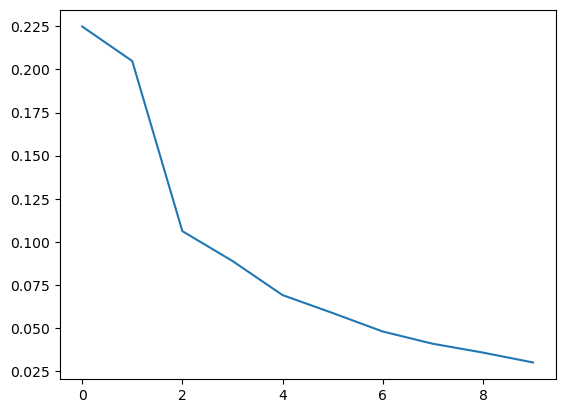

In [28]:
# Zscore the data
meanBalancedAll = np.mean(cleanX, axis = 0)
sdBalancedAll = np.std(cleanX, axis = 0, ddof=1)
ZBalancedAll = (cleanX - meanBalancedAll)/sdBalancedAll

# PCA the data
pcaBalanced = PCA(n_components=10, svd_solver='full')
Z_PCA_Balanced_All = pcaBalanced.fit_transform(ZBalancedAll)

print("Shape of Z_PCA_All:", Z_PCA_Balanced_All.shape)

# Plot the explainable variance
plt.plot(pcaBalanced.explained_variance_ratio_)

(4340, 10)


Text(0.5, 1.0, 'PCA of the data, balanced and zscored, 10 components, 2 dimensions')

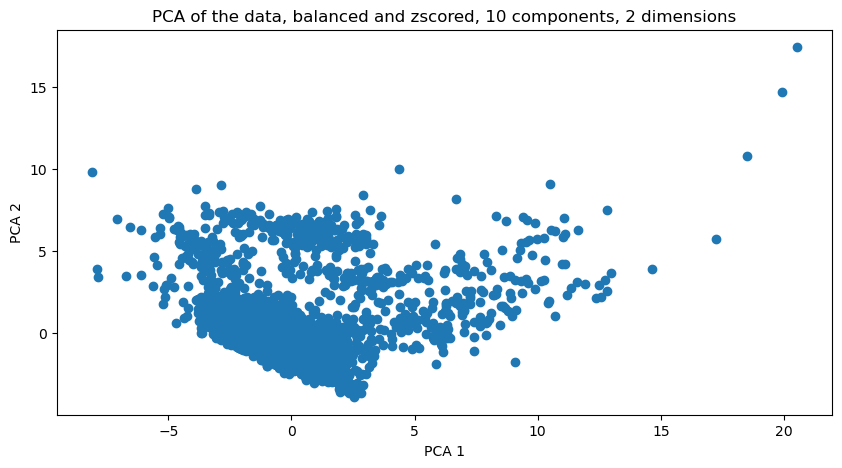

In [29]:
print(Z_PCA_Balanced_All.shape)
# Plot the first two components
plt.figure(figsize=(10, 5))
plt.scatter(Z_PCA_Balanced_All[:,0], Z_PCA_Balanced_All[:,1], cmap = 'tab20')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of the data, balanced and zscored, 10 components, 2 dimensions')


In [30]:
# Take the z-scored PCA data and run UMAP on it

MAXSYLL = 40
umapFit = umap.UMAP(
        n_neighbors=int(len(Z_PCA_Balanced_All)/MAXSYLL),
        min_dist=0.1,
        n_components=3,
        random_state=42).fit(Z_PCA_Balanced_All)

umapAll = umapFit.transform(Z_PCA_Balanced_All)

# umapAllData = umapFit.transform(Z_PCA_Balanced_All)

/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP colored by soundsep defined call type')

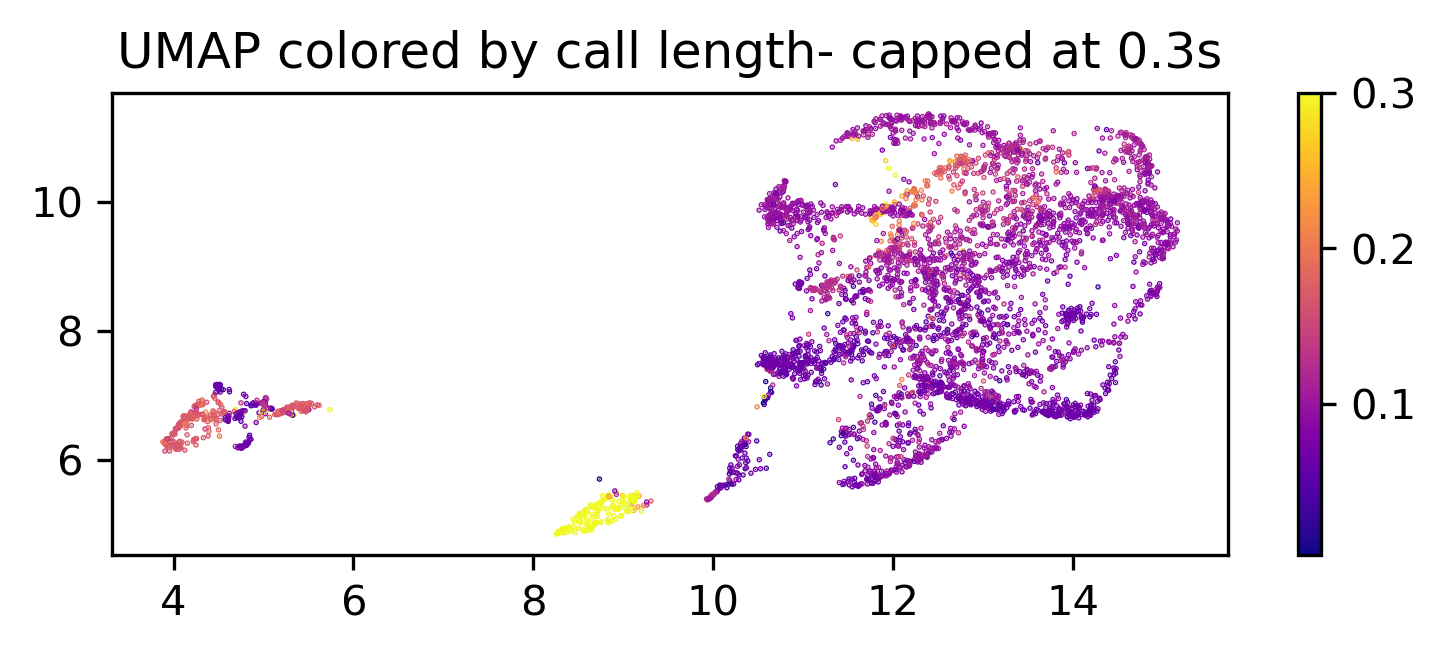

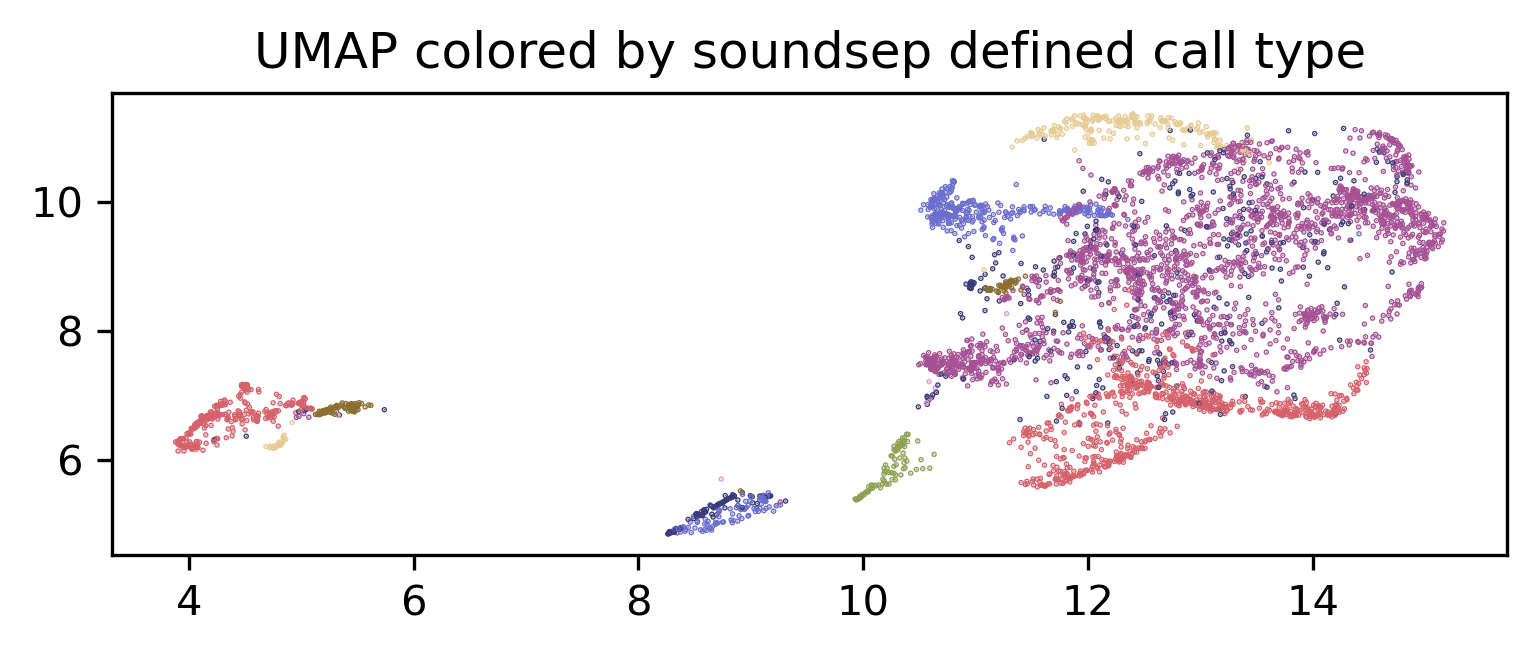

In [31]:
# shift the color index so that 0-.5s contains most of the color range.
# and plot the umap

c=cleanX[:,-1]
c[c>.3]=.3
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=c, cmap='plasma')
plt.title('UMAP colored by call length- capped at 0.3s')
plt.colorbar()

# plot the UMAP and color by the original tags of the call type
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=cleanTags['calltype'].astype('category').cat.codes, cmap='tab20b')
plt.title('UMAP colored by soundsep defined call type')



## Now let's use some clustering algorithms to assign new tags to our data.
## Afterwards we can re-save the SoundSep tags and look at the syllables there

In [32]:
# Let's cluster the UMAP data
# HDBSCAN
min_cluster_size = 15
min_samples = 15
epsilon = 0.7
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=epsilon)
clusterer.fit(umapAll)


HDBSCAN(cluster_selection_epsilon=0.7, min_cluster_size=15, min_samples=15)

Counter({8: 3097, 1: 302, 7: 295, 5: 209, 2: 184, 3: 102, 0: 89, 9: 43, 6: 19})


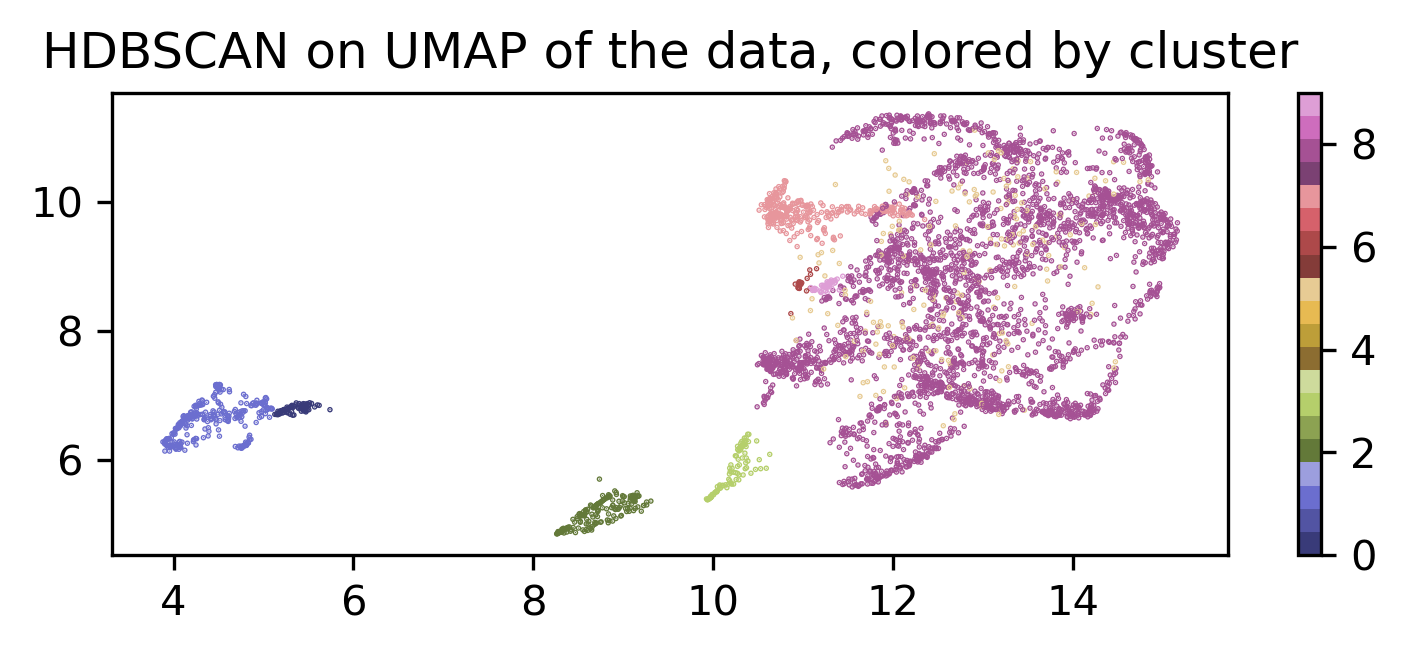

In [53]:
# Plot the clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clusterer.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of the data, colored by cluster')
plt.colorbar()

#print the number data points in each cluster
print(Counter(clusterer.labels_))

In [34]:
# print the number of calls in each cluster and the unclassified
print('Number of calls in each cluster and the unclassified')
print(Counter(clusterer.labels_))



Number of calls in each cluster and the unclassified
Counter({4: 3663, 1: 302, 2: 184, 3: 102, 0: 89})


In [11]:
# # plot some spectrograms from each cluster
# # get the indices of the calls in each cluster
# # cluster 0
# num_to_plot = 4
# for cluster_num in np.unique(clusterer.labels_):
#     print(f'cluster_num = {cluster_num}')
#     if len(np.where(clusterer.labels_ == cluster_num)[0]) < num_to_plot:
#         temp_num_to_plot = len(np.where(clusterer.labels_ == cluster_num)[0])
#         print(f"cluster {cluster_num} has less than {num_to_plot} calls, plotting {temp_num_to_plot} calls instead")
#     else:
#         temp_num_to_plot = num_to_plot
#     cluster_indices = np.where(clusterer.labels_ == cluster_num)
#     # print(f'cluster_indices = {cluster_indices}')
#     # get the first num_to_plot calls in the cluster
#     for i in range(temp_num_to_plot):
#         # print(f'cluster {cluster_num}, call {i}')
#         # print(f'index = {cluster_indices[0][i]}')
#         print(f'raw file name = {files_list[cluster_indices[0][i]]}')
#         # print(f'call type = {vocSelTableFull.iloc[cluster_indices[0][i],2]}')
#         # print(f'bird = {vocSelTableFull.iloc[cluster_indices[0][i],0]}')
#         # print(f'call length = {vocSelTableFull.iloc[cluster_indices[0][i],-1]}')
#         db_ind = {cluster_indices[0][i] }
#         # print(f'db_ind = {db_ind}')

#         fname = files_list[cluster_indices[0][i]]
#         start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
#         stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]

#         # cut everything after ' "] ' but keep the "]
#         fname = fname.split('"]')[0] + '"]'
#         fname = f'{fname}_{start_i}_{stop_i}.wav'

#         # cut 'call_' in the filename but save everything before and after it
#         fname = fname.split('call_')
#         fname = f'{fname[0]}{fname[1]}'
#         # cut 'bird_' in the filename but save everything after it
#         fname = fname.split('bird_')[1]
#         # print(f'fname no call = {fname}')
        
#         # read wave file using scipy
#         print(f"reading a spectrogram from {fname}")
#         fs, w = read(os.path.join(base_folder, "wavs", fname))
#         print(f"w is lenght {len(w)}")
#         # w = read(os. fname)
#         # myBioSound = BioSound()
#         # myBioSound.readh5(fname)
#         # w = myBioSound.wave
        
#         plot_a_spectrogram(w, fs=fs, title=fname)
#         plt.show()
#         # # play the sound
#         # ipd.Audio(w, rate=fs)
#         print('\n  ')


## Take just the biggest cluster and re-plot it in a new umap space and recluster it and plot those identites


biggest cluster = 4


Text(0.5, 1.0, 'old UMAP of cluster 4')

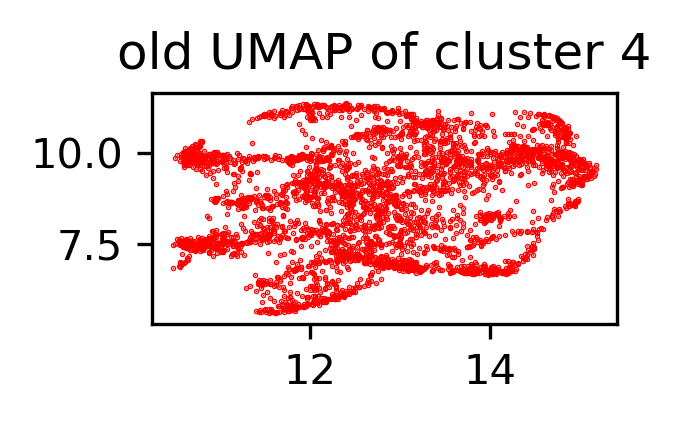

In [36]:
# take the biggest cluster and plot the UMAP of it
biggest_cluster = Counter(clusterer.labels_).most_common(1)[0][0]
print(f'biggest cluster = {biggest_cluster}')
cluster_ind = np.where(clusterer.labels_ == biggest_cluster)[0]

# cluster_ind = np.where(clusterer.labels_ == 7)[0]
cluster_old_umap =  umapAll[cluster_ind,:]
plt.figure(figsize=(2,1), dpi=300)
plt.scatter(cluster_old_umap[:, 0], cluster_old_umap[:, 1], s=0.1, c='r')
plt.title(f"old UMAP of cluster {biggest_cluster}")

Text(0.5, 1.0, 'PCA of the data, balanced and zscored, 10 components, 2 dimensions')

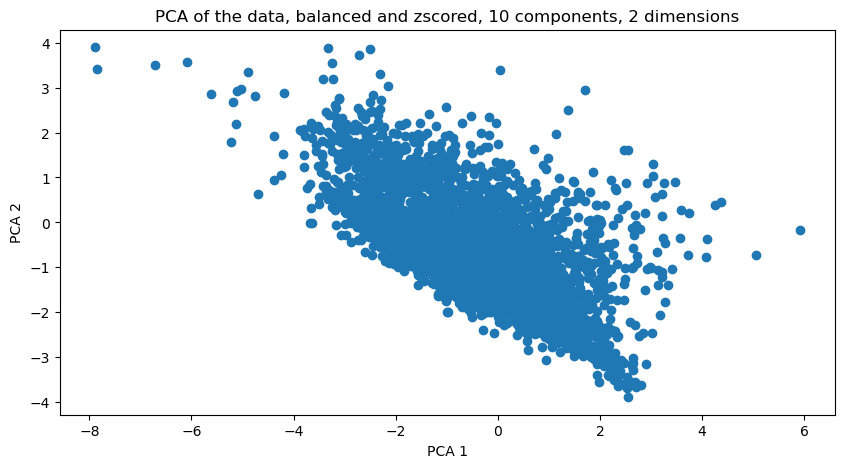

In [37]:
# but let's try making a new umap fit just based on this cluster
cluster_data = Z_PCA_Balanced_All[cluster_ind,:]

# plot it pca space
plt.figure(figsize=(10, 5))
plt.scatter(cluster_data[:,0], cluster_data[:,1], cmap = 'tab20')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of the data, balanced and zscored, 10 components, 2 dimensions')

/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


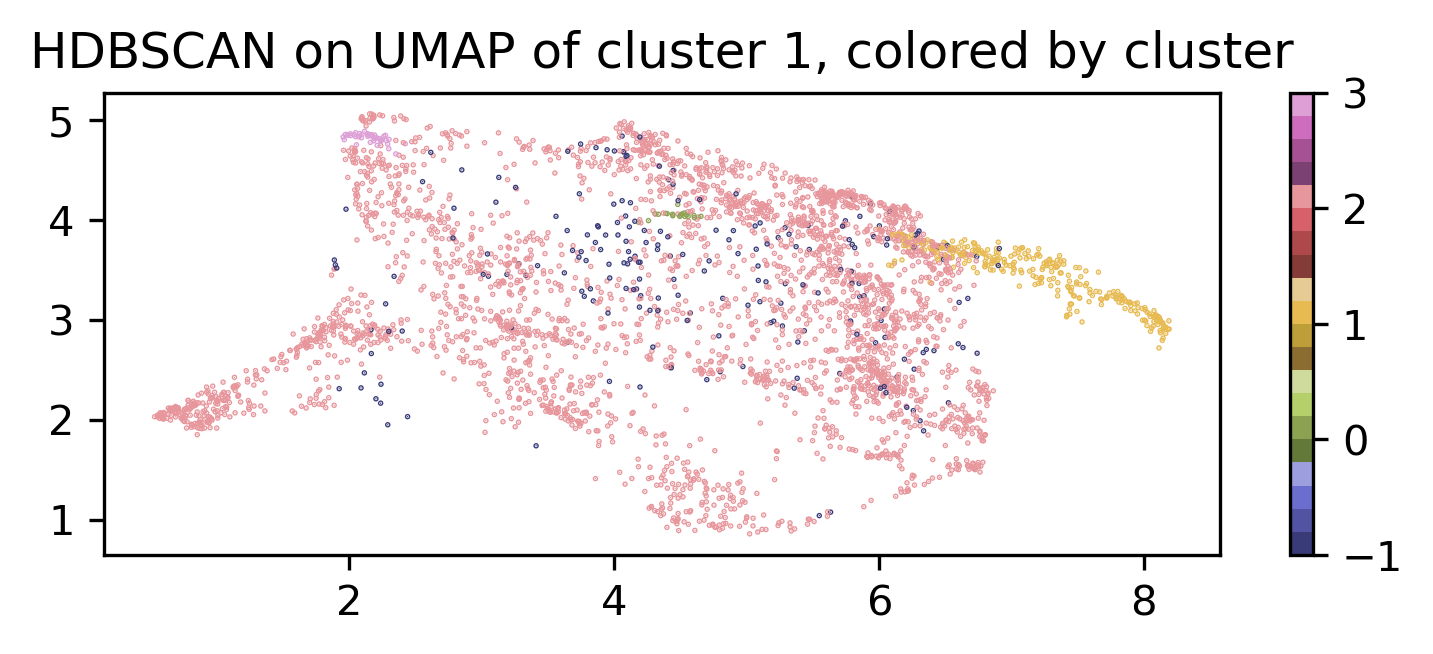

In [38]:
# make a new umap fit
umapFitCluster = umap.UMAP(
        n_neighbors=int(len(cluster_data)/MAXSYLL),
        min_dist=0.1,
        n_components=4,
        random_state=42).fit(cluster_data)

# project the data into the new umap
umapClusterData = umapFitCluster.transform(cluster_data)

# now let's cluster the cluster
min_cluster_size = 15
min_samples = 15
cluster_selection_epsilon = 0.5
clustererCluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon)
clustererCluster.fit(umapClusterData)

# Plot the new umap with new clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapClusterData[:, 0], umapClusterData[:, 1], s=0.1, c=clustererCluster.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of cluster 1, colored by cluster')
plt.colorbar()



In [39]:
# print the number of calls in each cluster and the unclassified
print('Number of calls in each cluster and the unclassified')
print(Counter(clustererCluster.labels_))


Number of calls in each cluster and the unclassified
Counter({2: 3097, 1: 295, -1: 209, 3: 43, 0: 19})


## ok, this looks good, let's update our original UMAP with the new cluster labels

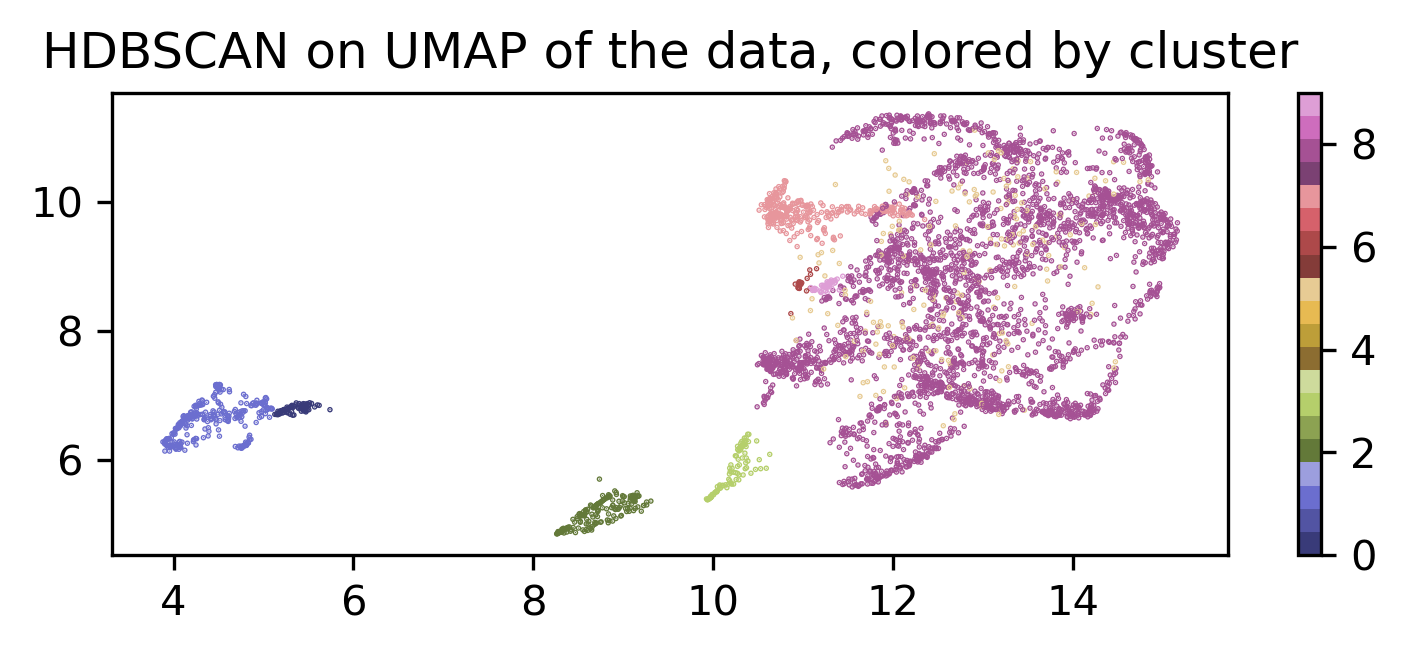

In [40]:
# update the cluster labels
clustererCluster.labels_ += np.max(clusterer.labels_) + 2
clusterer.labels_[cluster_ind] = clustererCluster.labels_
 
# Plot the clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clusterer.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of the data, colored by cluster')
plt.colorbar()


# I've noticed my females don't have any DCs clustered. Let's try to find them

In [41]:
# The DCs (distance calls) of the females are hiding in the biggest cluster. 
# Let's replot the biggest cluster, just looking at the females calls (BluGre1214F and WHiWhi0914F)
# get the indices of the calls in each cluster
# cluster 0

# 

In [42]:
vocSelTableFull

,Bird,calltype,fund,devfund,cvfund,maxfund,minfund,F1,F2,F3,...,entT,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords,callLength
0,BroGre1354M,"[""1""]",508.574590,-0.740855,0.045986,527.472527,436.363636,1664.044399,3561.528246,8596.893613,...,0.989150,0,BroGre1354M,0,705034,709502,tet,0.0,[11.813441 10.158026 8.204752],0.093083
1,BluGre1214F,"[""6""]",523.880794,-1.720430,0.011674,533.333333,516.129032,3271.703942,6280.586421,9217.829837,...,0.986979,1,BluGre1214F,2,739121,741816,tet,5.0,[10.289108 8.867108 3.8716762],0.056146
2,BluGre1214F,"[""2""]",548.575055,-2.208039,0.027101,564.705882,516.129032,4135.587818,9121.142787,NaN,...,0.960172,2,BluGre1214F,2,773851,776369,hat,1.0,[9.031709 7.9875793 2.4193041],0.052458
3,BluGre1214F,"[""6""]",557.333804,-2.713336,0.036705,592.592593,527.472527,3192.273235,6348.161057,9158.343416,...,0.982954,3,BluGre1214F,2,844891,848558,tet,5.0,[10.432616 8.651451 3.9261248],0.076396
4,BroGre1354M,"[""5""]",560.232975,-0.867444,0.035327,578.313253,516.129032,2570.895759,4398.845756,9123.647713,...,0.976569,4,BroGre1354M,0,910549,913839,tet,4.0,[10.93499 7.944698 0.92982405],0.068542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,WhiWhi1541M,"[""5""]",518.037891,-1.209025,0.040681,539.325843,475.247525,1927.627306,3946.935002,9088.130784,...,0.990364,4339,WhiWhi1541M,3,297302736,297305283,tet,4.0,[12.446056 7.7917695 2.9063237],0.053062
4340,BluGre1214F,"[""6""]",536.911375,0.723694,0.153731,592.592593,298.136646,1827.897792,4833.507703,8912.761732,...,0.989058,4340,BluGre1214F,2,297324812,297329004,tet,5.0,[13.918158 10.1539955 3.8789632],0.087333
4341,BluGre1214F,"[""6""]",567.024101,0.350191,0.102408,600.000000,296.296296,1765.890567,4526.155286,8829.029019,...,0.994484,4341,BluGre1214F,2,297367001,297371644,tet,5.0,[14.02288 10.04855 4.029904],0.096729
4342,BluGre1214F,"[""6""]",557.353786,0.768246,0.171243,615.384615,290.909091,1829.396367,4179.381920,8804.060975,...,0.974212,4342,BluGre1214F,2,298070022,298074525,tet,5.0,[12.321278 9.2719965 5.2556705],0.093812


In [43]:
# our umap coordinates will be updated in soundsep via segments.csv
# we will make coordinates for the bad calls as well, but they will be the mean of the good calls
coords = umapAll[:,0:3] # first three dimensions of umap (even though it plots 2)
bad_coords = np.mean(coords, axis=0)
vocSelTableFull['coords'] = [(0,0)]*len(vocSelTableFull)
j=0
for i in range(len(vocSelTableFull)):
    if i in indGood:
        # vocSelTableFull.at[vocSelTableFulli,'coords'] = (coords[j])
        vocSelTableFull.at[i,'coords'] = (coords[j])
        j+=1
    else:
        print(f"bad index = {i}")
        vocSelTableFull.at[i,'coords'] = (bad_coords)
        # vocSelTableFull.iloc[i]['coords'] = (bad_coords)    



bad index = 468
bad index = 913
bad index = 1443
bad index = 2727


In [44]:
# Ok these clusters look ok let's save them to the original df, which will then be used to update segments.csv
# First we need to add the cluster labels to the original df
vocSelTableFull['new_clusters'] = -2 # add a new column to the df
vocSelTableFull['new_clusters'][indGood] = clusterer.labels_ + 1# add the cluster labels to the new column from the first clustering
vocSelTableFull['new_clusters'][indBad] = -2 # add the unclassified calls to the new column
print('unique new clusters:', np.unique(vocSelTableFull['new_clusters']))

print('Number of calls in each cluster and the unclassified')
print(Counter(vocSelTableFull['new_clusters']))


unique new clusters: [-2  1  2  3  4  6  7  8  9 10]
Number of calls in each cluster and the unclassified
Counter({9: 3097, 2: 302, 8: 295, 6: 209, 3: 184, 4: 102, 1: 89, 10: 43, 7: 19, -2: 4})


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_6675/243277233.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocSelTableFull['new_clusters'][indGood] = clusterer.labels_ + 1# add the cluster labels to the new column from the first clustering
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_6675/243277233.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocSelTableFull['new_clusters'][indBad] = -2 # add the unclassified calls to the new column


In [45]:
# yeah that looks fine. 
# to resave the segments.csv file with the new cluster labels we need to put the new cluster labels back into the segments.csv file
# first we need to get the start and stop indices of the calls that we have in the vocSelTableFull
# we can then use these to replace the cluster labels in the segments.csv file
# we can then save the segments.csv file back to the original location

import json
syllTable['coords'] = vocSelTableFull['coords']
for i in range(len(vocSelTableFull)):
    start_index = vocSelTableFull['StartIndex'].iloc[i]
    stop_index = vocSelTableFull['StopIndex'].iloc[i]
    cluster_label = vocSelTableFull['new_clusters'].iloc[i]
    syllTable.loc[syllTable['StartIndex'] == start_index, 'Tags'] = json.dumps(list([str(cluster_label)]))

print(len(syllTable))
syllTable.to_csv(syll_file_name, index=False)
print(f"saved {syll_file_name} on {datetime.datetime.now()}")

# vocSelTableFull.to_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5'), 'callTable', mode = 'w')
# print('File saved to', os.path.join(base_folder, 'vocSelTableAmp.h5'))

4344
saved /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv on 2024-04-26 10:53:49.961447


In [46]:
syllTable

,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords
0,0,BroGre1354M,0,705034,709502,"[""8""]",0.0,"[10.697502, 9.804635, 7.993754]"
1,1,BluGre1214F,2,739121,741816,"[""9""]",5.0,"[10.666748, 7.427887, 3.884933]"
2,2,BluGre1214F,2,773851,776369,"[""4""]",1.0,"[10.273127, 5.794117, 2.64628]"
3,3,BluGre1214F,2,844891,848558,"[""9""]",5.0,"[10.74689, 7.3378167, 3.9408872]"
4,4,BroGre1354M,0,910549,913839,"[""9""]",4.0,"[12.070142, 6.447742, 1.3894552]"
...,...,...,...,...,...,...,...,...
4339,4339,WhiWhi1541M,3,297302736,297305283,"[""9""]",4.0,"[13.107664, 6.9023438, 3.5997097]"
4340,4340,BluGre1214F,2,297324812,297329004,"[""9""]",5.0,"[13.785383, 9.68441, 4.2628775]"
4341,4341,BluGre1214F,2,297367001,297371644,"[""9""]",5.0,"[13.857406, 9.577206, 4.476639]"
4342,4342,BluGre1214F,2,298070022,298074525,"[""9""]",5.0,"[12.200228, 8.624041, 5.4423275]"


In [47]:
# you have to copy and paste these into the tags.csv file
# The unique tags
tags = np.unique(syllTable['Tags'])

# Copy and paste this output to tags.csv
print(',TagName')
i=0
for itag, tag in enumerate(tags):
    print('{},{}'.format(itag, tag[2:-2]))
    # print(tag)
    i+=1

,TagName
0,-2
1,1
2,10
3,2
4,3
5,4
6,6
7,7
8,8
9,9


# The data is now saved. I add some manual clustering, below, after which you will have to save the data again if you want

In [48]:
# This is particular to the knowledge I get from looking at soundsep umap, for 14_38_03_18_07_2023
# clusters 0, 6, 7, 9, 10 are various contact calls of all birds
# cluster 1 are wingflaps
# cluster 2 and 3 are DCs of BroGreM, and also calls of BluGreF
# cluster 4 are "hat" (?) calls of all birds
# cluster 5 doesn't exist
# cluster 8 are the DC calls of WhiWhiM

# group the various contact calls together
ccs = [0, 6, 7, 9, 10]
for cc in ccs:
    ind = np.where(vocSelTableFull['new_clusters'] == cc)[0]
    vocSelTableFull['new_clusters'][ind] = "tet"

# group the wingflaps together
# find the index of the wingflaps
ind = np.where(vocSelTableFull['new_clusters'] == 1)[0]
vocSelTableFull['new_clusters'][ind] = "WF"

# group the DCs of WhiWhiM together
ind = np.where(((vocSelTableFull['new_clusters'] == 8) & (vocSelTableFull['Bird'] == "WhiWhi1541M")))[0]
vocSelTableFull['new_clusters'][ind] = "DC"

# DCs of BroGreM
ind = np.where(((vocSelTableFull['new_clusters'] == 2) | (vocSelTableFull['new_clusters'] == 3)) & (vocSelTableFull['Bird'] == "BroGre1354M"))[0]
vocSelTableFull['new_clusters'][ind] = "DC"

# calls of BluGreF
ind = np.where(((vocSelTableFull['new_clusters'] == 2) | (vocSelTableFull['new_clusters'] == 3)) & (vocSelTableFull['Bird'] == "BluGre1214F"))[0]
vocSelTableFull['new_clusters'][ind] = "call"

# "hat" calls of all birds
ind = np.where(vocSelTableFull['new_clusters'] == 4)[0]
vocSelTableFull['new_clusters'][ind] = "hat"




    

/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_6675/2186882671.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocSelTableFull['new_clusters'][ind] = "tet"


In [49]:
# now save it all again
import json
for i in range(len(vocSelTableFull)):
    start_index = vocSelTableFull['StartIndex'].iloc[i]
    stop_index = vocSelTableFull['StopIndex'].iloc[i]
    cluster_label = vocSelTableFull['new_clusters'].iloc[i]
    syllTable.loc[syllTable['StartIndex'] == start_index, 'Tags'] = json.dumps(list([str(cluster_label)])) # formats the cluster label as a string that can be read by soundsep


syllTable.to_csv(syll_file_name, index=False)

print(f'saved syllable table to {syll_file_name} on {datetime.datetime.now()}')


saved syllable table to /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv on 2024-04-26 10:53:50.513180


In [50]:
# project_dir = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023'
# seg_df = pd.read_csv(os.path.join(project_dir,'_appdata/save/segments.csv'))
# new_coords = umapAll.astype(float)    # n x 3 array
# seg_df['Coords'] = None
# seg_df.loc[indGood,'Coords'] = [json.dumps(list(x)) for x in new_coords]
# seg_df.to_csv(os.path.join(project_dir,'_appdata/save/segments.csv'))

# print(f'saved segments.csv to {os.path.join(project_dir,"_appdata/save/segments.csv")} on {datetime.datetime.now()}')

NameError: name 'df' is not defined

In [ ]:
[set([t for t in json.loads(tag_str)]) for tag_str in seg_df.Tags.unique()]

[{'10'}, {'9'}, {'4'}, {'6'}, {'3'}, {'8'}, {'1'}, {'2'}, {'7'}, {'-2'}, {'0'}]